# Exercise with fractals

In [1]:
from matplotlib import pyplot as plt
import numpy as np

Notes
- another benefit of modular code: easier to parallelize

In [2]:
def fractals_base(max_iter=256, center=-0.8+0.0j, extent=3.0+3.0j):
    width = 256
    height = 256
    scale = max((extent / width).real, (extent / height).imag)
    print(f"scale is {scale}")

    # compute the set  
    result = np.zeros((height, width), int) # x, y, z: z is the number of iterations until convergence; (x,y) are the coordinates?
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height // 2)*1j) * scale # this defines the complex number
            z = 0
            for k in range(max_iter):
                z = z**2 + c
                if (z * z.conjugate()).real > 4.0: # this defines the complement of the Mandelbrot set (?); ie, the set of C for which the sequences diverges(?)
                    break
            result[j, i] = k
    # plot 
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_extent = (width + 1j * height) * scale
    z1 = center - plot_extent / 2
    z2 = z1 + plot_extent
    ax.imshow(result**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag)) # extent defines the coordinates to be shown 
        # https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html
    ax.set_xlabel("$\Re(c)$") # real part
    ax.set_ylabel("$\Im(c)$") # imaginary part 


scale is 0.01171875


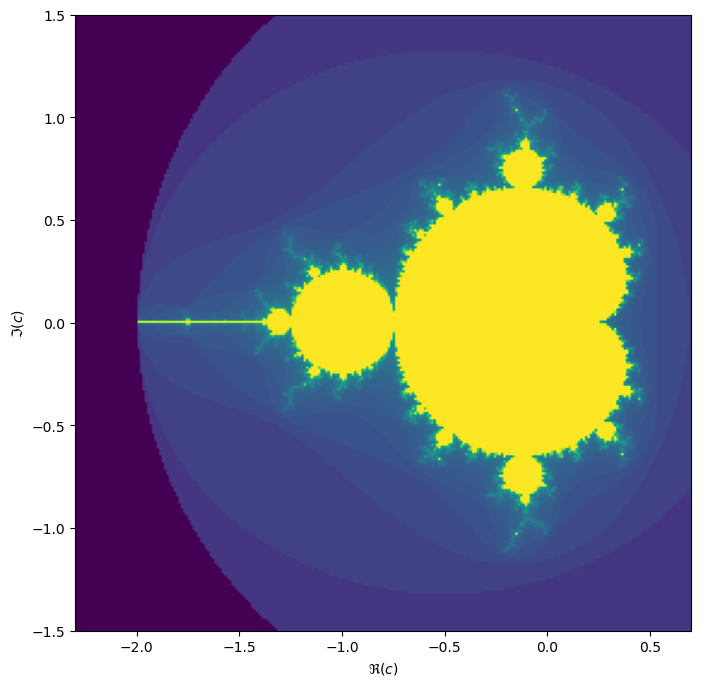

In [3]:
max_iter = 256 # why do we choose exponentials of 2?
center = -0.8+0.0j
extent = 3.0+3.0j
fractals_base(max_iter=max_iter, center=center, extent=extent)

scale is 1.953125e-05


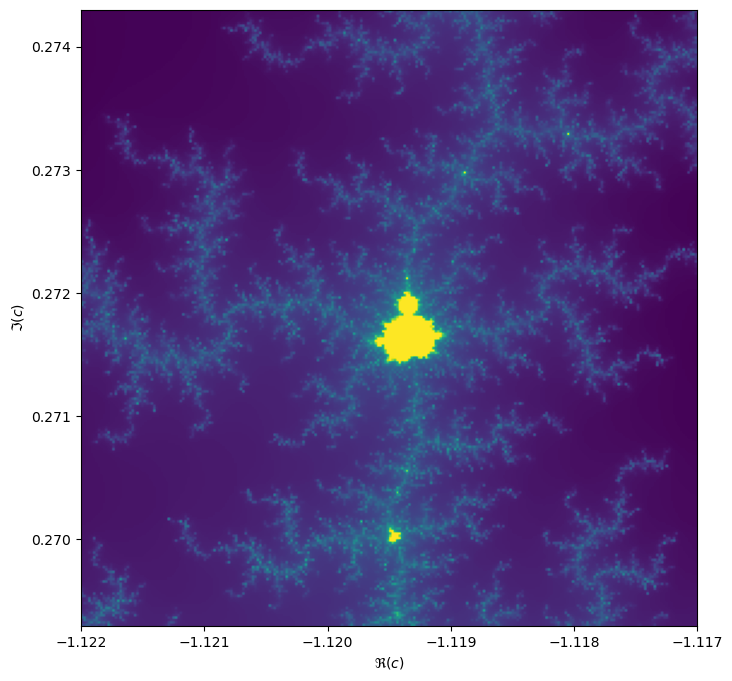

In [4]:
max_iter = 1024 # why do we choose exponentials of 2?
center = -1.1195+0.2718j
extent = 0.005+0.005j
fractals_base(max_iter=max_iter, center=center, extent=extent)

## Solution

In [5]:
from bounding_box import BoundingBox

test_case = BoundingBox(1024, 1024, -1.1195+0.2718j, 0.005+0.005j)

In [6]:
import matplotlib  # type:ignore
matplotlib.use(backend="Agg")
from matplotlib import pyplot as plt
import numpy as np

def plot_fractal(box: BoundingBox, values: np.ndarray, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = None
    plot_extent = (box.width + 1j * box.height) * box.scale
    z1 = box.center - plot_extent / 2
    z2 = z1 + plot_extent
    ax.imshow(values, origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag),
              cmap=matplotlib.colormaps["jet"])
    ax.set_xlabel("$\Re(c)$")
    ax.set_ylabel("$\Im(c)$")
    return fig, ax

In [7]:
def fractals(box: BoundingBox, max_iter=1024):
    # compute the set  
    result = np.zeros((box.height, box.width), int) # x, y, z: z is the number of iterations until convergence; (x,y) are the coordinates?
    for j in range(box.height):
        for i in range(box.width):
            c = box.center + (i - box.width // 2 + (j - box.height // 2)*1j) * box.scale # this defines the complex number
            z = 0
            for k in range(max_iter):
                z = z**2 + c
                if (z * z.conjugate()).real > 4.0: # this defines the complement of the Mandelbrot set (?); ie, the set of C for which the sequences diverges(?)
                    break 
            result[j, i] = k # lower k --> earlier divergence/iteration stop? 
    return result 

In [143]:
test_box = BoundingBox(1024, 1024, -1.1195+0.2718j, 0.005+0.005j)
# test_box = BoundingBox(256, 256, -1.1195+0.2718j, 0.005+0.005j)
target_data = fractals(test_box)

In [144]:
target_data

array([[117, 116, 202, ...,  53,  54,  54],
       [143,  94,  94, ...,  53,  53,  54],
       [162,  91,  90, ...,  53,  53,  53],
       ...,
       [ 36,  36,  36, ...,  90, 106,  53],
       [ 36,  36,  36, ...,  58,  76,  54],
       [ 36,  36,  36, ...,  52,  52,  55]])

In [135]:
fig, ax = plot_fractal(box = test_box, values = target_data)


In [136]:
fig.show()

/tmp/ipykernel_3340/89474557.py:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


### Function with numpy

In [154]:
from itertools import product 

def fractals_np(box: BoundingBox, max_iter=1024):
    # TODO: check order of input and adjust if necessary
    inputs = list(product(np.arange(box.height), np.arange(box.width)))
    cs = [center + (i - box.width // 2 + (j - box.height // 2)*1j) * box.scale for (i, j) in inputs]
    cs = np.array(cs)

    z = np.zeros(cs.shape)
    diverged = np.zeros(cs.shape)
    result = np.zeros(z.shape) - np.ones(z.shape)

    for i in range(max_iter): 
        z = (z**2).T * (np.ones(diverged.shape) - diverged) + cs
        diverged = (z * z.conjugate()).real > 4.0
        cond = np.logical_and(diverged, result == -1)
        result = np.where(cond, i, result)
    
    result = np.where(result == -1, i, result)    
    return result

In [155]:
test_box = BoundingBox(1024, 1024, -1.1195+0.2718j, 0.005+0.005j)

test_values = fractals_np(test_box)


In [145]:
assert test_values.mean() == target_data.mean()

In [146]:
%timeit fractals_np(test_box)

18.8 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [147]:
%timeit fractals(test_box)

11.8 s ± 575 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So this is even slower than the raw version. why?

### pass function to numba; make wrapper

In [176]:
import numba 

@numba.jit(nogil=True)
def fractals_np_numba(cs, z, diverged, result, max_iter=1024): 
    # TODO: check order of input and adjust if necessary
    # inputs = list(product(np.arange(height), np.arange(width)))
    # cs = [center + (i - width // 2 + (j - height // 2)*1j) * scale for (i, j) in inputs]
    # cs = np.array(cs)

    # z = np.zeros(cs.shape)
    # diverged = np.zeros(cs.shape)
    # result = np.zeros(z.shape) - np.ones(z.shape)

    for i in range(max_iter): 
        z = (z**2).T * (np.ones(diverged.shape) - diverged) + cs
        diverged = (z * z.conjugate()).real > 4.0
        cond = np.logical_and(diverged, result == -1)
        result = np.where(cond, i, result)
    
    result = np.where(result == -1, i, result)    
    return result



def compute_mandelbrot(
    box: BoundingBox, 
    max_iter = 1024):
    inputs = list(product(np.arange(box.height), np.arange(box.width)))
    cs = [center + (i - box.width // 2 + (j - box.height // 2)*1j) * box.scale for (i, j) in inputs]
    cs = np.array(cs)

    z = np.zeros(cs.shape)
    diverged = np.zeros(cs.shape)
    result = np.zeros(z.shape) - np.ones(z.shape)
    return fractals_np_numba(cs=cs, z=z, diverged=diverged, result=result, max_iter=max_iter)

insights
- "approach it from a C perspective" with (nested) for loops 
    - `np.where` etc do not perform well on numba 
- the vectorized approach here is inefficient because one runs the loop until `max_iter` for each element in z. The nested for loop, in contrast, stops as soon as any given branch diverges
- the multiplication `(z**2).T * (np.ones(diverged.shape) - diverged)` is extremely inefficient
- type hints often help resolve type inference in numba 
    - for type hints for 2-dimensional arrays: google search
- (there are numpy functions that generate the complex numbers directly)


### New approach, starting from original function: numba

In [212]:


@numba.jit(nogil=True)
def fractals_numba(result, 
    height: int, width: int, center: complex, scale: complex, max_iter: int):
    # compute the set  
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height // 2)*1j) * scale
            z = 0.0+0.0j
            for k in range(max_iter):
                z = z**2 + c
                if (z * z.conjugate()).real > 4.0: 
                    break 
            result[j, i] = k 
    return result 

def compute_mandelbrot(
    box: BoundingBox,
    max_iter: np.int64
):
    result = np.zeros((test_box.height, test_box.width), np.int64)
    return fractals_numba(
        result=result,
        height=box.height,
        width=box.width,
        center=box.center,
        scale=box.scale,
        max_iter=max_iter
    )


In [213]:
data = compute_mandelbrot(test_box, 1024)

In [188]:
data.mean() == target_data.mean()

True

In [214]:
%timeit -r 1 compute_mandelbrot(test_box, 1024)

285 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### numba parallel

In [233]:
from typing import Any, Optional 

@numba.njit(nogil=True, parallel=True)
def fractals_numba(result, 
    height: int, width: int, center: complex, scale: complex, max_iter: int):
    # compute the set  
    for j in numba.prange(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height // 2)*1j) * scale 
            z = 0.0+0.0j
            for k in range(max_iter):
                z = z**2 + c
                if (z * z.conjugate()).real > 4.0: 
                    break 
            result[j, i] = k
    return result 


def compute_mandelbrot(
    box: BoundingBox,
    max_iter: np.int64,
    throttle: Any = None,
    result: Optional[np.ndarray[np.int64]] = None
):
    if throttle is not None:
        numba.set_num_threads(throttle)
    result = result if result is not None else np.zeros((box.height, box.width), np.int64)
    return fractals_numba(
        result=result,
        height=box.height,
        width=box.width,
        center=box.center,
        scale=box.scale,
        max_iter=max_iter
    )


In [234]:
%timeit -r 1 compute_mandelbrot(test_box, 1024)

82.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### parallel, but with domain splitting